# GSVA and clustering


## Initialize the environment

In [1]:
library(tidyverse)
library(data.table)
library(Seurat)
library(lattice)
library(edgeR)
library(GSVA)
library(factoextra)

── Attaching packages ─────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

载入程辑包：‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Attaching SeuratObject

载入需要的程辑包：limma

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
whole <- readRDS("./data/whole_annot.rds")

In [3]:
get_lcpm <- function(sobj) {
    edata <- round(AggregateExpression(sobj,
                                       group.by = "desc")[[1]], 0)
    dge <- DGEList(edata) %>%
        calcNormFactors() %>%
        cpm(log = TRUE, normalized.lib.sizes = TRUE)
    return(dge)
}

In [ ]:
whole_splt <- SplitObject(whole, split.by = "group")
lcpm <- lapply(whole_splt, get_lcpm)
oc_lfc <- lcpm$OC - lcpm$H
od_lfc <- lcpm$OD - lcpm$H

In [53]:
go_gs <- readRDS("~/bioresource/genesets/gobp.rds")

## Run GSVA

In [ ]:
doc_gsva <- gsva(oc_lfc, go_gs, kcdf = "Gaussian", min.sz = 3)
dod_gsva <- gsva(od_lfc, go_gs, kcdf = "Gaussian", min.sz = 3)

In [ ]:
colnames(doc_gsva) <- str_c(colnames(doc_gsva), "_OC")
colnames(dod_gsva) <- str_c(colnames(dod_gsva), "_OD")

In [ ]:
interpaths <- intersect(rownames(doc_gsva), rownames(dod_gsva))
comb_gsva <- cbind(doc_gsva[interpaths,], dod_gsva[interpaths,])
comb_gsva %>% write.csv("./results/enrich/comb_gsva.csv")

In [4]:
comb_gsva <- read.csv("./results/enrich/comb_gsva.csv", row.names = 1)

## PCA

In [2]:
library(RColorBrewer)

In [5]:
gsva_dr <- t(scale(as.matrix(comb_gsva)))
# gsva_dr <- read.csv("./umap/gsva_dr.csv", row.names = 1) %>%
    # as.matrix()

In [6]:
meta_dr <- data.table(
    cell = rownames(gsva_dr),
    cell_type = map_chr(rownames(gsva_dr),
                \(x){str_match(x, "(.*)_(.*)")[2]}),
    comparison = map_chr(rownames(gsva_dr),
                \(x){str_match(x, "(.*)_(.*)")[3]})
)

In [7]:
pca_gsva <- prcomp(gsva_dr)
str(pca_gsva)

List of 5
 $ sdev    : num [1:32] 27.3 25.3 19.9 19.4 18.8 ...
 $ rotation: num [1:7611, 1:32] -0.00118 -0.00912 -0.01491 -0.02032 -0.00818 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7611] "10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS" "2 OXOGLUTARATE METABOLIC PROCESS" "2FE 2S CLUSTER ASSEMBLY" "3 PHOSPHOADENOSINE 5 PHOSPHOSULFATE BIOSYNTHETIC PROCESS" ...
  .. ..$ : chr [1:32] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:7611] 0.248 0.103 0.422 0.253 0.28 ...
  ..- attr(*, "names")= chr [1:7611] "10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS" "2 OXOGLUTARATE METABOLIC PROCESS" "2FE 2S CLUSTER ASSEMBLY" "3 PHOSPHOADENOSINE 5 PHOSPHOSULFATE BIOSYNTHETIC PROCESS" ...
 $ scale   : Named num [1:32] 0.291 0.267 0.255 0.281 0.26 ...
  ..- attr(*, "names")= chr [1:32] "Adipose.Progenitor.Cells_OC" "Mesothelial.Cells_OC" "Th1_OC" "Cytotoxic.T.cells_OC" ...
 $ x       : num [1:32, 1:32] 1.54 23.17 26.87 46.7 33.26 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3

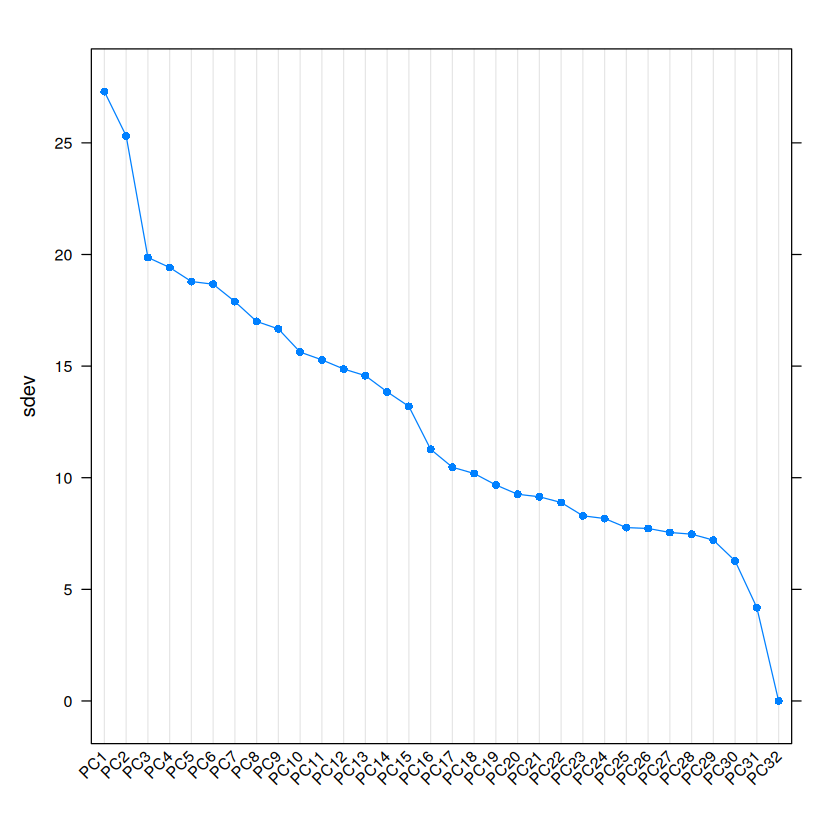

In [8]:
# svg("./plots/module/diag/sdev.svg", width = 8, height = 6)
with(
    data.table(
        pc = factor(1:32, levels = c(1:32), labels = str_c("PC", 1:32)),
        sdev = pca_gsva$sdev
    ),
    dotplot(sdev ~ pc, type = c("l", "p"), scales = list(x = list(rot = 45)))
)
# dev.off()

In [ ]:
write.csv(gsva_dr, "./umap/gsva_dr.csv")
write.csv(meta_dr, "./umap/meta_dr.csv")

## UMAP generation and DBSCAN

In [108]:
gsva_umap <- fread("./umap/umap_vis.csv")
gsva_umap %>% head()

V1,UMAP1,UMAP2,cell_type,comp
<chr>,<dbl>,<dbl>,<chr>,<chr>
Adipose Progenitor Cells_OC,1.761044,8.255908,Adipose Progenitor Cells,OC
Mesothelial Cells_OC,1.791992,8.229280,Mesothelial Cells,OC
Th1_OC,2.239834,7.239420,Th1,OC
Cytotoxic T cells_OC,2.132469,7.061890,Cytotoxic T cells,OC
gamma-delta T_OC,2.123312,7.169233,gamma-delta T,OC
M2-like Macrophages_OC,1.971984,6.935367,M2-like Macrophages,OC


In [109]:
gsva_embed <- read.csv("./umap/umap_embed.csv", row.names = 1) %>%
    as.matrix()
gsva_embed[1:6, 1:6]

,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5
Adipose Progenitor Cells_OC,1.761044,8.255908,7.399982,2.901629,6.749967,7.672102
Mesothelial Cells_OC,1.791992,8.229280,7.396703,3.601432,6.367839,7.585785
Th1_OC,2.239834,7.239420,7.364596,6.553372,5.162396,6.808460
Cytotoxic T cells_OC,2.132469,7.061890,7.496428,5.980829,5.234009,6.866055
gamma-delta T_OC,2.123312,7.169233,7.454971,6.338323,5.195191,6.857956
M2-like Macrophages_OC,1.971984,6.935367,7.567345,5.867209,5.389836,6.894037


In [111]:
library(dbscan)


载入程辑包：‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram




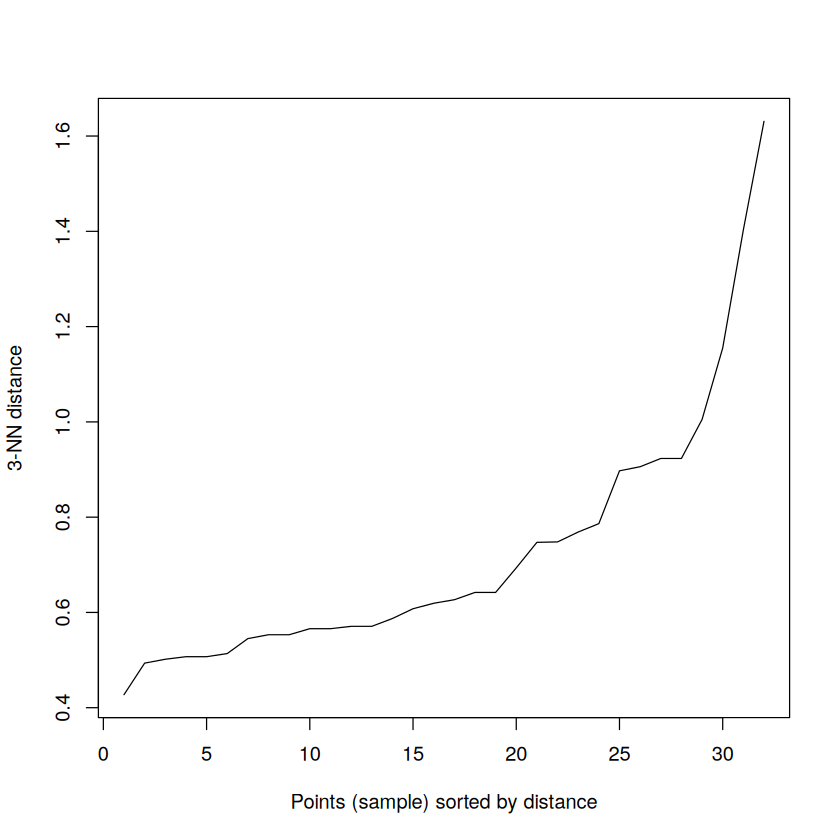

In [112]:
kNNdistplot(gsva_embed, k = 3)

In [113]:
clf <- dbscan(gsva_embed, eps = 0.9, minPts = 3)
clf$cluster

[1] 1 1 2 2 2 2 3 3 1 1 3 3 3 1 2 0 1 1 2 2 2 2 3 3 1 1 3 3 3 1 2 0

In [114]:
cluster_fct <- factor(clf$cluster, levels = 0:3,
                      labels = c("Unclustered", "Mod1", "Mod2", "Mod3"))
color_vec <- brewer.pal(4, "Set1")
color_vec[1] <- "#000000"
names(color_vec) <- levels(cluster_fct)
svg("./plots/module/umap.svg", width = 8, height = 6)
with(
    gsva_umap[,.(
        UMAP1, UMAP2, cell_type, comp,
        cluster = cluster_fct,
        colors = unname(color_vec[cluster_fct])
    )],
    xyplot(UMAP2 ~ UMAP1 | comp, groups = colors,
          panel = function(x, y, groups, ..., subscripts){
              fill <- groups[subscripts]
              panel.text(x, y, label = cell_type, col = fill, ...)
          },
           key = list(
               space = list("top"),
               columns = 4,
               text = list(levels(cluster_fct)),
               point = list(col = color_vec)
           )
    )
)
dev.off()

png 
  2

### Cluster-wise function comparison

In [62]:
meta_dr <- meta_dr[,.(cell, cell_type,
           comparison = as_factor(comparison), cluster = cluster_fct)] 
meta_dr %>%
    fwrite("./results/module/module_info.csv")

In [18]:
meta_dr

cell,cell_type,comparison,cluster
<chr>,<chr>,<chr>,<chr>
Adipose.Progenitor.Cells_OC,Adipose.Progenitor.Cells,OC,Mod1
Mesothelial.Cells_OC,Mesothelial.Cells,OC,Mod1
Th1_OC,Th1,OC,Mod2
Cytotoxic.T.cells_OC,Cytotoxic.T.cells,OC,Mod2
gamma.delta.T_OC,gamma.delta.T,OC,Mod2
M2.like.Macrophages_OC,M2.like.Macrophages,OC,Mod2
M1.like.Macrophages_OC,M1.like.Macrophages,OC,Mod3
cDC1_OC,cDC1,OC,Mod3
Fibro.inflammatory.Progenitors_OC,Fibro.inflammatory.Progenitors,OC,Mod1


In [63]:
mod_stat <- data.table(
    cell = colnames(comb_gsva),
    comb_gsva %>% t() %>%
        as.data.frame()
)
mod_stat <- merge(mod_stat, meta_dr) %>%
    melt(id.vars = c("cell", "cell_type", "comparison", "cluster"),
         value.name = "score",
         variable.name = "pathway"
        )
mod_stat %>% head()

cell,cell_type,comparison,cluster,pathway,score
<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>
Adipocytes_OC,Adipocytes,OC,Mod1,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,0.15808534
Adipocytes_OD,Adipocytes,OD,Mod1,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,0.25202365
Adipose.Progenitor.Cells_OC,Adipose.Progenitor.Cells,OC,Mod1,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,-0.08136298
Adipose.Progenitor.Cells_OD,Adipose.Progenitor.Cells,OD,Mod1,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,-0.18567782
B.Cells_OC,B.Cells,OC,Mod3,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,0.07113921
B.Cells_OD,B.Cells,OD,Mod3,10 FORMYLTETRAHYDROFOLATE METABOLIC PROCESS,-0.41191651


In [64]:
clst_vec <- levels(mod_stat$cluster)
clst_vec

[1] "Unclustered" "Mod1"        "Mod2"        "Mod3"

In [65]:
mod_wilcox <- mod_stat[,.(
    cluster = clst_vec,
    pval = map_dbl(clst_vec, \(clst){
        wilcox.test(.SD[cluster == clst, score],
                    .SD[cluster != clst, score])$p.value
    }),
    diff = map_dbl(clst_vec, \(clst){
        mean(.SD[cluster == clst, score]) -
        mean(.SD[cluster != clst, score])
    })
), by = "pathway"][order(pval), .(
    pathway, diff, pval, padj = p.adjust(.SD[, pval], method = "BH")
), by = "cluster"][order(cluster, -diff, padj)]
fwrite(mod_wilcox, "./results/module/mod_test.csv")

In [6]:
mod_wilcox <- fread("./results/module/mod_test.csv")
meta_dr <- fread("./results/module/module_info.csv")

In [66]:
gsea_signif <- fread("./results/enrich/combined_gsea.csv")

In [67]:
gsea_sigpaths <- gsea_signif[padj < 0.05, pathway]

In [68]:
mod_wilcox_sigpaths <- mod_wilcox[padj < 0.05, pathway]

In [69]:
intersect(gsea_sigpaths, mod_wilcox_sigpaths)

[1] "IMMUNE RESPONSE"                                           
 [2] "CELL ACTIVATION"                                           
 [3] "ADAPTIVE IMMUNE RESPONSE"                                  
 [4] "INFLAMMATORY RESPONSE"                                     
 [5] "REGULATION OF IMMUNE SYSTEM PROCESS"                       
 [6] "NEGATIVE REGULATION OF HYDROGEN PEROXIDE METABOLIC PROCESS"
 [7] "CELL MIGRATION"                                            
 [8] "LOCOMOTION"                                                
 [9] "DIVALENT INORGANIC CATION HOMEOSTASIS"                     
[10] "LEUKOCYTE DIFFERENTIATION"                                 
[11] "REGULATION OF CYTOSOLIC CALCIUM ION CONCENTRATION"

In [144]:
mod_wilcox[pathway %in% 
           intersect(gsea_sigpaths, mod_wilcox_sigpaths)][
    cluster != "Unclustered"][padj < 0.05]

cluster,pathway,diff,pval,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Mod1,IMMUNE RESPONSE,-0.07158688,2.148554e-03,0.030004846
Mod1,REGULATION OF IMMUNE SYSTEM PROCESS,-0.08834559,6.332132e-04,0.015698324
Mod1,ADAPTIVE IMMUNE RESPONSE,-0.09697935,5.890355e-05,0.005534752
Mod1,DIVALENT INORGANIC CATION HOMEOSTASIS,-0.10621022,7.626460e-04,0.017589389
Mod1,CELL ACTIVATION,-0.11687229,1.883364e-04,0.009247922
Mod1,REGULATION OF CYTOSOLIC CALCIUM ION CONCENTRATION,-0.11876819,1.883364e-04,0.009247922
Mod1,INFLAMMATORY RESPONSE,-0.12009063,1.543614e-03,0.024838153
Mod1,LEUKOCYTE DIFFERENTIATION,-0.14069188,5.233115e-04,0.014123845
Mod2,NEGATIVE REGULATION OF HYDROGEN PEROXIDE METABOLIC PROCESS,0.25923491,2.148554e-03,0.029097226


In [70]:
bw_vis <- mod_stat[pathway %in% intersect(gsea_sigpaths, mod_wilcox_sigpaths)]
bw_vis <- merge(bw_vis, mod_wilcox)
color_breaks <- do.breaks(range(bw_vis$padj), 100)
color_vec <- colorRampPalette(brewer.pal(8, "Spectral"))(100)
bw_vis <- mutate(bw_vis, color = level.colors(padj,
                at = color_breaks, col.regions = color_vec))

In [139]:
svg("./plots/module/sigpath.svg", width = 12, height = 9)
with(
    bw_vis[cluster != "Unclustered"],
    bwplot(score ~ cluster | pathway,
           scale = list(x = list(rot = 45)),
           panel = function(x, y, ...){
               panel.bwplot(x, y, ...)
               panel.abline(h = mean(y), lty = 4)
           }, par.strip.text = list(cex = 0.4)
          )
)
dev.off()

png 
  2

In [11]:
library(ComplexHeatmap)

载入需要的程辑包：grid

ComplexHeatmap version 2.13.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [51]:
hm_paths <- mod_wilcox[,head(.SD, 30),
                       by = "cluster"][
    cluster != "Unclustered", pathway]

In [48]:
cell_mask <-  meta_dr[cluster != "Unclustered",][order(cluster)]

In [49]:
library(RColorBrewer)
color_vec <- brewer.pal(4, "Set1")[2:4]
names(color_vec) <- str_c("Mod", 1:3)

In [52]:
png("./plots/module/heatmap.png", width = 12, height = 16, units = "in", res = 300)
Heatmap(
    comb_gsva[hm_paths, cell_mask$cell],
    top_annotation = columnAnnotation(
        module = cell_mask$cluster,
        col = list(
            module = color_vec
        )
    ),
    cluster_columns = FALSE,
    show_column_names = FALSE,
    name = "GSVA score",
    row_dend_side = "right",
    row_names_side = "left",
    row_names_max_width = unit(15, "cm"),
    row_names_gp = gpar(cex = 0.5),
    row_km = 3
)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

## Module based GSEA

In [8]:
cell_dct <- meta_dr[comparison == "OC"]$cluster
names(cell_dct) <-  meta_dr[comparison == "OC"]$cell_type
whole[["module"]] <- unname(cell_dct[whole$desc])

In [10]:
saveRDS(whole, "./data/whole_mod.rds")

### Fetch DEGs and FC list

In [59]:
library(edgeR)
library(fgsea)

In [67]:
module1_edata <- AggregateExpression(
    subset(whole, module == "Mod1"),
    group.by = "sample"
)$RNA %>% as.matrix() %>% round()
module2_edata <- AggregateExpression(
    subset(whole, module == "Mod2"),
    group.by = "sample"
)$RNA %>% as.matrix() %>% round()
module3_edata <- AggregateExpression(
    subset(whole, module == "Mod3"),
    group.by = "sample"
)$RNA %>% as.matrix() %>% round()
pdata <- data.frame(
    row.names = colnames(module1_edata),
    group = c(rep("LC", 2), rep("OC", 3), rep("OD", 3))
)

In [68]:
fetch_gsea <- function(edata){
    dge <- DGEList(counts = edata, group = factor(pdata$group))
    design <- model.matrix(~ 0 + factor(pdata$group))
    colnames(design) <- levels(factor(pdata$group))
    rownames(design) <- colnames(edata)
    cont <- makeContrasts(contrasts = c("OC-LC", "OD-LC"), levels = design)
    dge <- dge[filterByExpr(dge, group = pdata$group),
               keep.lib.sizes = FALSE] %>%
        calcNormFactors() %>%
        estimateDisp(design)
    fit <- glmFit(dge, design, robust = TRUE)
    oc_degs <- glmLRT(fit, contrast = cont[, 1]) %>%
    topTags(n = Inf) %>%
    as.data.frame()
    oc_degs <- data.table(
        gene = rownames(oc_degs),
        oc_degs,
        comparison = "OC"
    )
    od_degs <- glmLRT(fit, contrast = cont[, 2]) %>%
        topTags(n = Inf) %>%
        as.data.frame()
    od_degs <- data.table(
        gene = rownames(od_degs),
        od_degs,
        comparison = "OD"
    )
    combined_degs <- rbind(oc_degs, od_degs)
    oc_gsea <- fgsea(
        go_gs, combined_degs[comparison == "OC",]
        [order(-logFC), .(gene, logFC)] %>% deframe(),
        minSize = 3, eps = 0.0
         )[order(padj)]
    od_gsea <- fgsea(
        go_gs, combined_degs[comparison == "OD",]
        [order(-logFC), .(gene, logFC)] %>% deframe(),
        minSize = 3, eps = 0.0
    )[order(padj)]
    return(list(
        "OC" = oc_gsea,
        "OD" = od_gsea
    ))
}

In [69]:
module1_gsea <- fetch_gsea(module1_edata)
module2_gsea <- fetch_gsea(module2_edata)
module3_gsea <- fetch_gsea(module3_edata)

In [115]:
plot_module_gsea <- function(gsea_lst, lab){
    oc_signif <- gsea_lst$OC[padj < 0.05][order(-abs(NES))]
    od_signif <- gsea_lst$OD[padj < 0.05][order(-abs(NES))]
    sigpath_union <- union(oc_signif[1:10, pathway], od_signif[1:10, pathway])
    p <- ggplot(data = NULL, aes(x = NES, y = fct_reorder(pathway, NES))) +
         geom_col(aes(fill = "Obese control"), alpha = 0.6,
                 data = gsea_lst$OC[pathway %in% sigpath_union]) +
        geom_col(aes(fill = "Obese diabetic"), alpha = 0.6,
                 data = gsea_lst$OD[pathway %in% sigpath_union]) +
        scale_y_discrete(label = \(x){str_wrap(x, width = 40)}) +
        scale_fill_manual(name = "Comparison",
                          values = brewer.pal(3, "Set1")[c(2, 1)]) +
        ylab("Pathway") +
        labs(title = paste0(lab, ": top 10 pathways"))
    return(p)
}

In [116]:
plot_module_gsea(module1_gsea, "Mod1") %>%
    ggsave("./plots/module/mod1_gsea.svg", ., width = 8, height = 6)

In [117]:
plot_module_gsea(module2_gsea, "Mod2") %>%
    ggsave("./plots/module/mod2_gsea.svg", ., width = 8, height = 6)

In [118]:
plot_module_gsea(module1_gsea, "Mod3") %>%
    ggsave("./plots/module/mod3_gsea.svg", ., width = 8, height = 6)